<b>Web Analytics DATA 620</b>

<b>Assignment: “Final Project”</b>

<b>Group - Chris Bloome / Mustafa Telab / Vinayak Kamath</b>

<b>Date - 16th July 2021</b>

--- 

Your project should incorporate one or both of the two main themes of this course: network analysis and text processing. You need to show all of your work in a coherent workflow, and in a reproducible format, such as an IPython Notebook or an R Markdown document. If you are building a model or models, explain how you evaluate the “goodness” of the chosen model and parameters. 


---

# Proposal



For our final project we will revisit a dataset from an earlier assignment, to apply the tools and concepts we have learned since.  The data is a collection of amazon reviews for fine foods.  We want to substitute the numerical rating for a more robust sentiment analysis of the review text; ultimately comparing how the structue of the network changes, controlling for the nature of the review.

The source of the data is snap.stanford.edu/data/web-Amazon.html; The csv file data includes:

- product/productId
- review/userId
- review/profileName
- review/helpfulness
- review/score
- review/time
- review/summary
- review/text

<b>Analysis Plan</b>
1. Read data into pandas dataframe.

2. Conduct sentiment analysis of the review texts to assign a classification and score.

3. Explore results, apply visualizations to understand the distribution of sentiment, and decide if the chosen classifications are useful or need to be redifined in step 2.

4. Build a projection network for each of the classifications; while integrating the sentiment scores into the edge attributes.

5. Compare centrality measures for each subgraph.  Define differences in network structure and identify important nodes for each.


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import random
import neo4j as neo
from sklearn import preprocessing
import numpy as np
import math
import re
from datetime import datetime
import nltk
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
import os
os.chdir('/Users/mustafatelab/Desktop/CUNY SPS MSDS/DATA 620 Web Analytics/SPS_MSDS_SMR21_DATA620')

For this exercise we are pulling product amazon.com product review data from 
https://snap.stanford.edu/data/web-Amazon.html

## Read Data


In [3]:
#Parsing instructions provided @https://snap.stanford.edu/data/web-Amazon.html
import gzip
import simplejson

def parse(filename):
  f = gzip.open(filename, 'rt', encoding = 'latin 1')
  entry = {}
  for l in f:
    l = l.strip()
    colonPos = l.find(':')
    if colonPos == -1:
      yield entry
      entry = {}
      continue
    eName = l[:colonPos]
    rest = l[colonPos+2:]
    entry[eName] = rest
  yield entry

After parsing the raw data, we move to transform it into a pandas dataframe

In [4]:
raw = []
for e in parse('Data/finefoods.txt.gz'):
  raw.append(e)

In [5]:
df = pd.DataFrame(raw)

In [6]:
df = df[df['review/time'].notnull()].reset_index()


In [7]:
timestamp = list(df['review/time'].astype(int))

In [8]:
#Convert timestamp to datetime format
df['date'] = [datetime.utcfromtimestamp(v).strftime('%Y-%m-%d') for v in timestamp]
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [9]:
df = df.loc[df['date'] > pd.datetime(year = df['date'].max().year - 1 , month = 1, day = 1)].reset_index()

/Users/mustafatelab/opt/anaconda3/envs/sps620env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


## Sentiment Analysis


In [10]:
print("Total Reviews")
print(len(df))
print("Distinct Products")
print(len(df['product/productId'].unique()))
print("Distinct Reviewers")
print(len(df['review/userId'].unique()))

Total Reviews
361610
Distinct Products
62433
Distinct Reviewers
171081


We see that there nearly every review is for a unique a product. If we had more reviews per prodcut, we might be able to do an analysis based on aggregate review and consistancy of word use. We still have plenety of options in this case, however. 

## (2) Conduct sentiment analysis of the review texts to assign a classification and score.

We have a field for Review/Summary and a second field for Review/Text, I beleive these are the bold part of the review you see on Amazon, and then the exposition below. We may as well concatenate these strings together for a larger sample per review.

In [11]:
df['review'] = df['review/summary'] + " " + df['review/text'] 

With a more robust review field, we will proceed by cleaning and tokenizing our review data. I borrowed a bit from [toward data science](https://towardsdatascience.com/detecting-bad-customer-reviews-with-nlp-d8b36134dc7e) to tokenize our reviews and flag with POS in a systematic way. 

In [12]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mustafatelab/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mustafatelab/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mustafatelab/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

    
def clean(i):
    i = str(i).lower()
    i = [j.strip(string.punctuation) for j in i.split(" ")]
    i = [j for j in i if not any(c.isdigit() for c in j)]
    s = stopwords.words('english')
    i = [x for x in i if x not in s]
    i = [t for t in i if len(t) > 0]
    pos_tags = pos_tag(i)
    i = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    i = [t for t in i if len(t) > 1]
    i = " ".join(i)
    return(i)

# clean text data
df["review_clean"] = df["review"].apply(lambda x: clean(x))

Now we can use NLTK's VADER (Valence Aware Dictionary for Sentiment Reasoning) to assign Sentiment values

In [14]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mustafatelab/nltk_data...


True

In [15]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [16]:
# I beleive this is a very "R" way of doing this. It works in Python but shows a warning. 
# Following code supresses warning 
import warnings
warnings.filterwarnings('ignore')

df['negative'] = ""
df['neutral'] = ""
df['positive'] = ""
df['compound'] = ""

for i in range(len(df)):
    sentiment = sia.polarity_scores(df['review_clean'][i])
    df['negative'][i] = sentiment['neg']
    df['neutral'][i] = sentiment['neu']
    df['positive'][i] = sentiment['pos']
    df['compound'][i] = sentiment['compound']


Vader provides a percent probability for Positive, Negative and Neutral values, such that the sum is 100%. It also provides a Compound score ranging from -1 to 1. I included the Positive/Negative/Neutral scores, however, we will focus on the compound score. Anything over 50% will be flagged as positive, with anything under 50% as negative. The middle range we will flag as neutral or unknown.

In [42]:
conditions = [
    (df['compound'] >= .5),
    (df['compound'] <= -.5),
    (df['compound'] < .5) & (df['compound'] > -.5)]

values = ['Positive', 'Negative', 'Neutral/Unknown']

df['Sentiment'] = np.select(conditions, values)

In [34]:
#convert to numeric for calculations
cols= ['Rating_Sentiment','review/score']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

Simialrly, we will treat any review with exactly 3 stars (as given by the user) as Neutral. Anything over as Positive and under as negative. 

In [43]:
conditions = [
    (df['review/score']) > 3,
    (df['review/score']) < 3,
    (df['review/score']) ==  3]

values = ['Positive', 'Negative', 'Neutral/Unknown']

df['Rating_Sentiment'] = np.select(conditions, values)

In [44]:
print(df.groupby('Rating_Sentiment')['product/productId'].count())
print("")
print(df.groupby(['Sentiment','Rating_Sentiment'])['product/productId'].count())

Rating_Sentiment
Negative            56468
Neutral/Unknown     28598
Positive           276538
Name: product/productId, dtype: int64

Sentiment        Rating_Sentiment
Negative         Negative             10304
                 Neutral/Unknown       1034
                 Positive              1983
Neutral/Unknown  Negative             18533
                 Neutral/Unknown       5364
                 Positive             14942
Positive         Negative             27631
                 Neutral/Unknown      22200
                 Positive            259613
Name: product/productId, dtype: int64


## (3) Explore results, apply visualizations to understand the distribution of sentiment, and decide if the chosen classifications are useful or need to be redifined in step 2.

We see that most of our reviews are positive. That being said, Vader seems to be great at selecting which reviews are positive. Due to the overwhelming number of positive reviews, lets restructure this data such that we are interesting in flagging reviews as "positive" or "other" and structure our analysis this way. 

In [45]:
df['Positive_Sentiment'] = df['compound']>.5
df['Positive_Review'] = df['review/score']>3

In [46]:
print(df.groupby(['Positive_Review','Positive_Sentiment'])['product/productId'].count())

Positive_Review  Positive_Sentiment
False            False                  35238
                 True                   49828
True             False                  16935
                 True                  259603
Name: product/productId, dtype: int64


Not bad! Lets calculate sensitivity and specificity. We will assume our model is trying to predict reviews which were rated positively by the review.

In [47]:
conditions = [
    (df['Positive_Sentiment'] == True) & (df['Positive_Review'] == True),
    (df['Positive_Sentiment'] == True) & (df['Positive_Review'] == False),
    (df['Positive_Sentiment'] == False) & (df['Positive_Review'] == True),
    (df['Positive_Sentiment'] == False) & (df['Positive_Review'] == False)]

values = ['TP', 'FP', 'FN', 'TN']

df['Category'] = np.select(conditions, values)

In [48]:
TP = len(df[df['Category']=="TP"])
FP = len(df[df['Category']=="FP"])
TN = len(df[df['Category']=="TN"])
FN = len(df[df['Category']=="FN"])


In [49]:
print("Sensitivity, percentage of reviews rated positive by the user that sentiment anaysis labled as positive:")
print(TP/(TP+FN))
print("")
print("Specificity, percentage of reviews rated negative (under 4 stars) by the user that sentiment anaysis labled as negative:")
print(TN/(TN+FP))
print("")
print("Percision, percentage of reviews rated positive by sentiment anaysis that the user rated as positive")
print(TP/(TP+FP))

Sensitivity, percentage of reviews rated positive by the user that sentiment anaysis labled as positive:
0.9387579463517296

Specificity, percentage of reviews rated negative (under 4 stars) by the user that sentiment anaysis labled as negative:
0.4142333192269714

Percision, percentage of reviews rated positive by sentiment anaysis that the user rated as positive
0.8389650848640753


One additional analysis I am interested in is review length. I suspect that short positive reviews may not contain enough positive words to be labeled as such by our model.

In [50]:
# Assuming there is exactly one space between each word, which we know that there is per our cleaning of the data. 
df['review length'] =df['review_clean'].str.count(' ') + 1

In [51]:
df.groupby(['Category'])['review length'].mean()

Category
FN    32.755491
FP    56.320751
TN    35.804359
TP    42.827439
Name: review length, dtype: float64

In [52]:
df.groupby(['Category'])['review length'].median()

Category
FN    23
FP    42
TN    28
TP    30
Name: review length, dtype: int64

**Review to make sure this holds true as sample changes** 

Interestingly enough, False Positives have the largest word count. It seems as though as reviews get longer, sentiment analysis becomes less accurate.  

# 3.b Visuals / Analysis

## Language

**20 Most Common Words in Dataset** 

In [53]:
# Join questions into long string 
word_list = ' '.join(df['review_clean'])

# Split string into individual words
word_list = word_list.split()

# Generate Dict with word count
word_list_ct = pd.Series(word_list).value_counts().to_dict()

# Convert Dict to DF
word_list_df = pd.DataFrame(list(word_list_ct.items()),columns = ['word','count']) 

word_list_df = word_list_df[word_list_df.word != "br"]

list(word_list_df[0:20]['word'])


['like',
 'taste',
 'good',
 'great',
 'love',
 'flavor',
 'coffee',
 'product',
 'one',
 'get',
 'make',
 'use',
 'food',
 'try',
 'buy',
 'tea',
 'would',
 'dog',
 'find',
 'well']

**20 Most Common Words in True Positive Reviews** 

In [54]:
# Join questions into long string 
word_list = ' '.join(df[df['Category']=='TP']['review_clean'])

# Split string into individual words
word_list = word_list.split()

# Generate Dict with word count
word_list_ct = pd.Series(word_list).value_counts().to_dict()

# Convert Dict to DF
word_list_df = pd.DataFrame(list(word_list_ct.items()),columns = ['word','count']) 

word_list_df = word_list_df[word_list_df.word != "br"]

list(word_list_df[0:20]['word'])


['good',
 'great',
 'like',
 'love',
 'taste',
 'flavor',
 'coffee',
 'one',
 'get',
 'make',
 'product',
 'use',
 'food',
 'try',
 'tea',
 'find',
 'buy',
 'dog',
 'well',
 'best']

**20 Most Common Words in True Negative Reviews** 

In [55]:
# Join questions into long string 
word_list = ' '.join(df[df['Category']=='TN']['review_clean'])

# Split string into individual words
word_list = word_list.split()

# Generate Dict with word count
word_list_ct = pd.Series(word_list).value_counts().to_dict()

# Convert Dict to DF
word_list_df = pd.DataFrame(list(word_list_ct.items()),columns = ['word','count']) 

word_list_df = word_list_df[word_list_df.word != "br"]

list(word_list_df[0:20]['word'])

['taste',
 'product',
 'like',
 'buy',
 'get',
 'one',
 'coffee',
 'flavor',
 'bad',
 'would',
 'make',
 'try',
 'use',
 'food',
 'order',
 'good',
 'box',
 'tea',
 'dog',
 'even']

**20 Most Common Words in False Negative or False Positive Reviews** 

In [56]:
# Join questions into long string 
word_list = ' '.join(df[((df['Category']=='FN') | (df['Category']=='FP'))]['review_clean'])

# Split string into individual words
word_list = word_list.split()

# Generate Dict with word count
word_list_ct = pd.Series(word_list).value_counts().to_dict()

# Convert Dict to DF
word_list_df = pd.DataFrame(list(word_list_ct.items()),columns = ['word','count']) 

word_list_df = word_list_df[word_list_df.word != "br"]

list(word_list_df[0:20]['word'])

['like',
 'taste',
 'good',
 'flavor',
 'product',
 'get',
 'coffee',
 'one',
 'would',
 'use',
 'make',
 'try',
 'buy',
 'food',
 'dog',
 'tea',
 'well',
 'go',
 'love',
 'really']

### Word Cloud 
Let's generate a word cloud for each of our categories:

In [59]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# dataset.drop(['labels'], axis = 1, inplace = True)

### True Positives

Reviews our model correctly identified as positive.

In [455]:
def wordgather(df, cat):
    words = ' '.join((df[df['Category']==cat]['review_clean']))
    words = words.split()
    words = [x for x in words if x != 'br']
    words = [x for x in words if "b r" not in x]
    words =  ' '.join(words)
    words_wc = WordCloud(height = 600, width = 600).generate(words)
    return words_wc

In [456]:
wc_TP = wordgather(df, 'TP')
wc_TN = wordgather(df, 'TN')
wc_FP = wordgather(df, 'FP')
wc_FN = wordgather(df, 'FN')

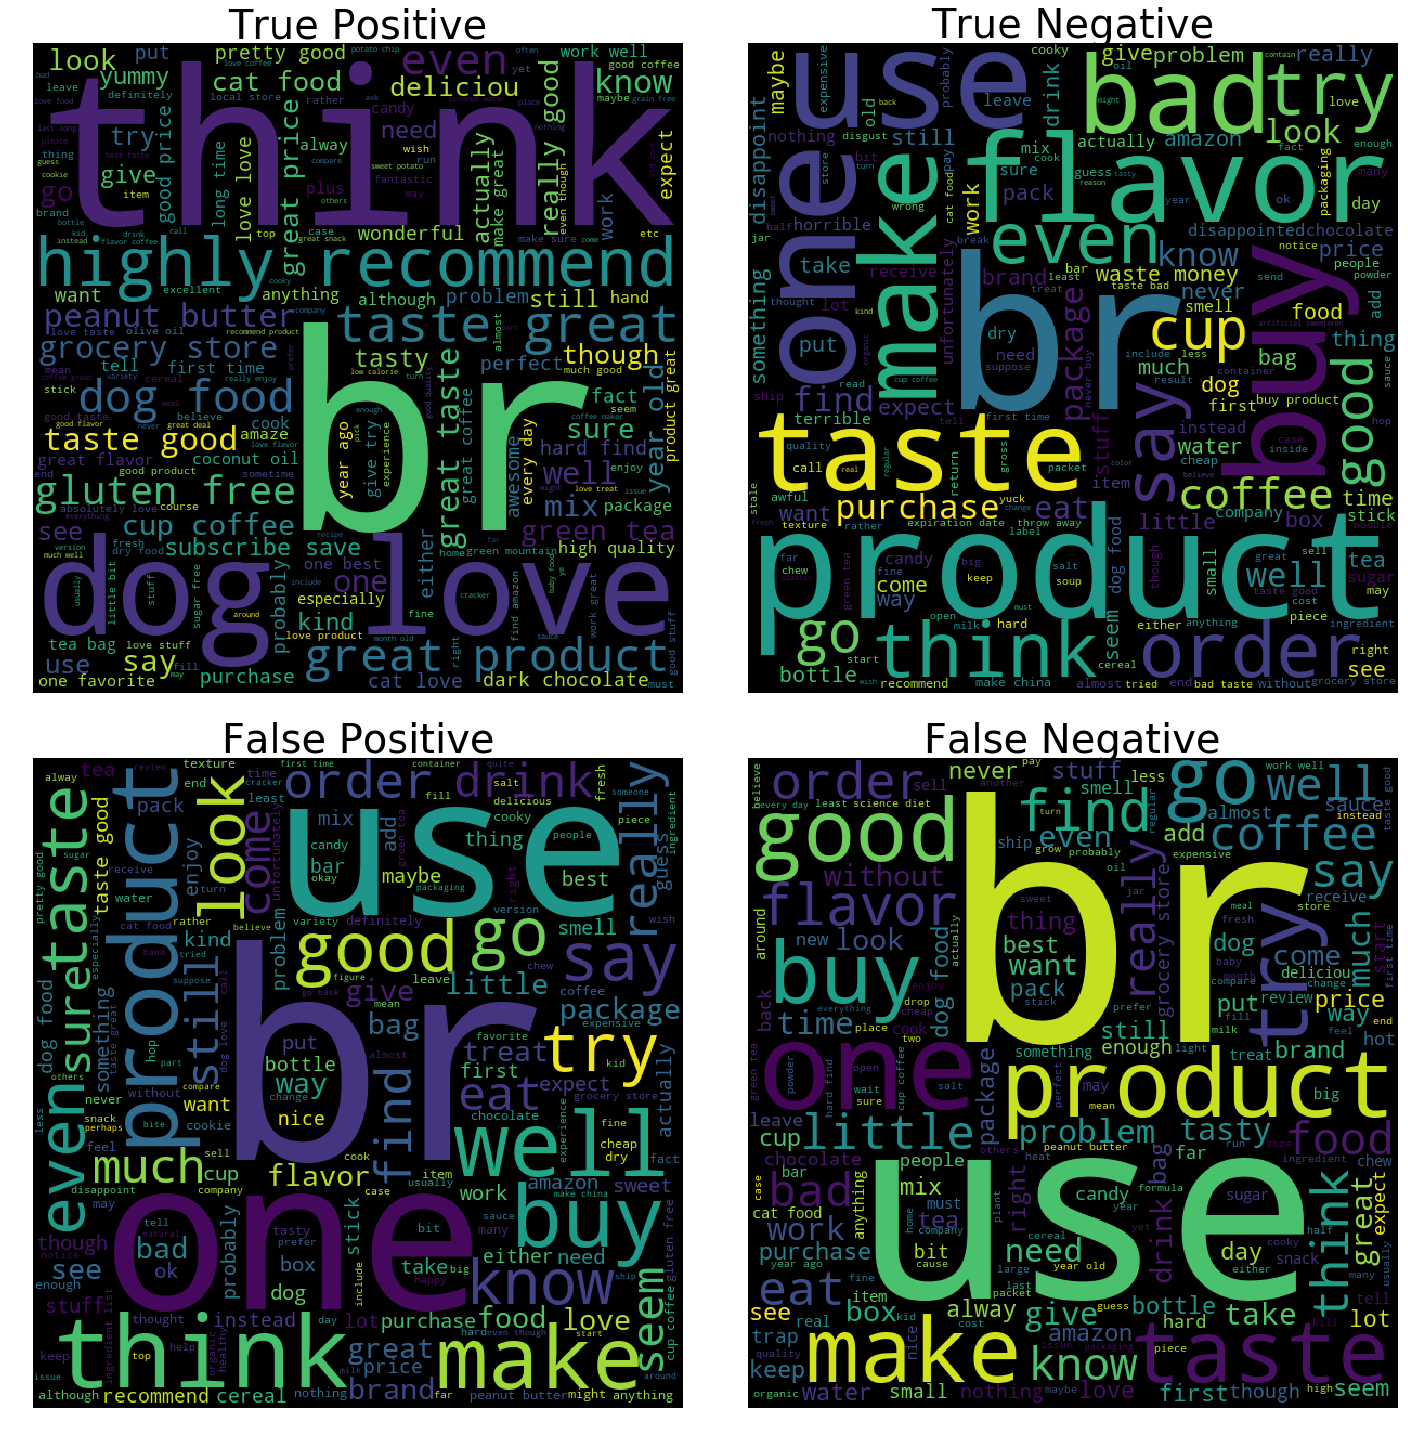

In [464]:
fig, axs = plt.subplots(2,2, figsize = (20, 20))
axs[0,0].imshow(wc_TP)
axs[0,0].axis('off')
axs[0,0].set_title('True Positive', fontsize = 40)
axs[0,1].imshow(wc_TN)
axs[0,1].axis('off')
axs[0,1].set_title('True Negative', fontsize = 40)
axs[1,0].imshow(wc_FP)
axs[1,0].axis('off')
axs[1,0].set_title('False Positive', fontsize = 40)
axs[1,1].imshow(wc_FN)
axs[1,1].axis('off')
axs[1,1].set_title('False Negative', fontsize = 40)
fig.tight_layout()
fig.show()

## Metric Visualizations

In [491]:
#Calculate Confusion Matrix
cf_matrix = confusion_matrix(df['Positive_Review'], df['Positive_Sentiment'])
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

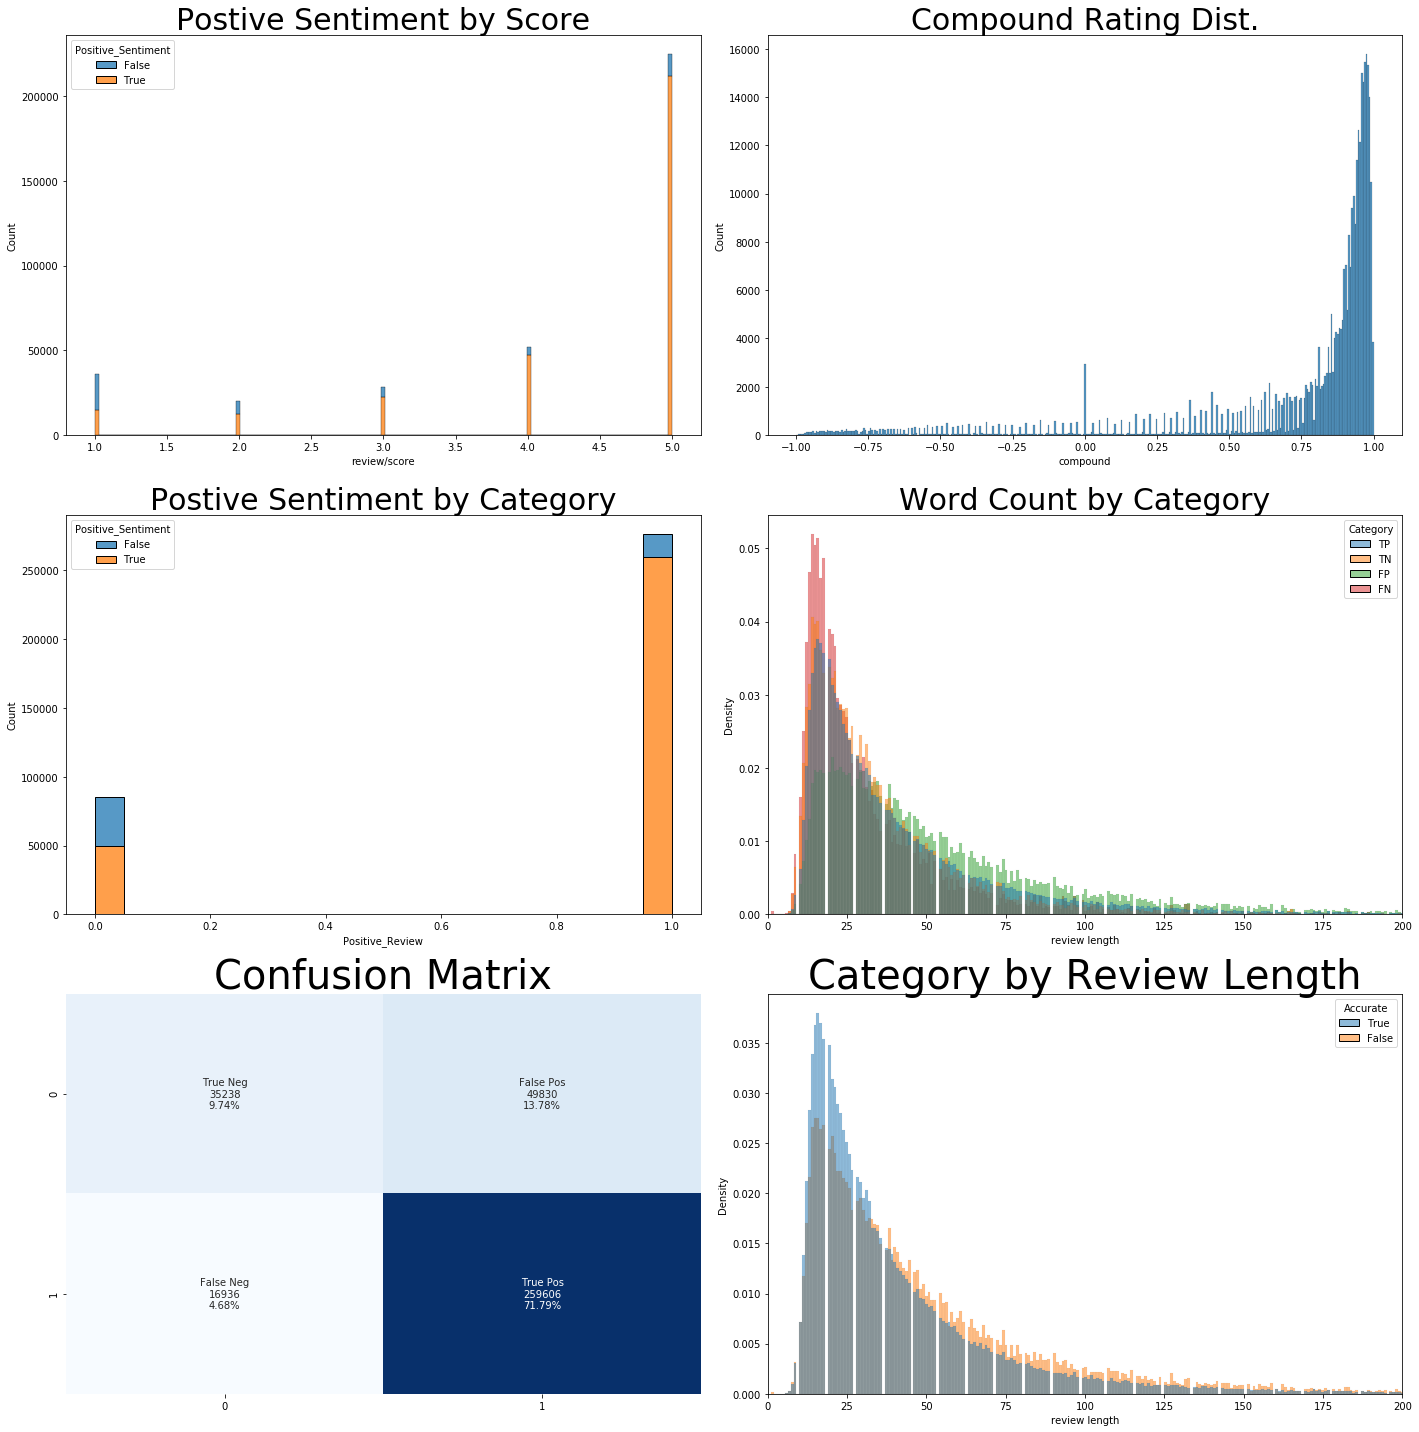

In [490]:
fig, axs = plt.subplots(3,2, figsize = (20, 20))
sns.histplot(data=df, x="compound", ax=axs[0,1])
axs[0,1].set_title('Compound Rating Dist.', fontsize = 30)
sns.histplot(data=df, x="review/score", hue='Positive_Sentiment', multiple="stack", ax=axs[0,0])
axs[0,0].set_title('Postive Sentiment by Score', fontsize = 30)
sns.histplot(data=df, x="Positive_Review", hue='Positive_Sentiment', multiple="stack", ax=axs[1,0])
axs[1,0].set_title('Postive Sentiment by Category', fontsize = 30)
sns.histplot(data=df, x="review length", hue='Category', stat='density',  common_norm=False, ax=axs[1,1]).set(xlim=(0, 200))
axs[1,1].set_title('Word Count by Category', fontsize = 30)

conditions = [
    (df['Category'] == "TP") | (df['Category'] == "TN"),
     (df['Category'] == "FP") | (df['Category'] == "FN")]
values = ["True", "False"]
df['Accurate'] = np.select(conditions, values)
sns.histplot(data=df, x="review length", hue='Accurate', stat='density',  common_norm=False, ax=axs[2,1]).set(xlim=(0, 200))
axs[2,1].set_title('Category by Review Length', fontsize = 40)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False, ax=axs[2,0])
axs[2,0].set_title('Confusion Matrix', fontsize = 40)
fig.tight_layout()
fig.show()

## Build Network

Sentiment Analysis is complete.  Now we turn to the network portion of the analysis.  We will examine the structure of the nodes to decide what insights can be drawn.

<BR>Firstly, we establish graph 'G'; integrating the results from the above sentiment analysis.  This will serve as the start of our network analysis.  The only filter applied to this point is removing those records where the review field was Null.

Edge Attributes
<br>'negative'
<br>'neutral'
<br>'positive'
<br>'compound'
<br>'review length'
<br>'Sentiment'
<br>'Category'


Node attributes;
<br>'Average Sentiment' - Aggregation of word analysis
<br>'Average Score' - Aggregation of user reviews
<br>'Type' - User vs Product to facilitate projection graph

In [342]:
#Convert Pandas dataframe into a graph; assign relevant fields as edge attributes
G = nx.from_pandas_edgelist(df, source = 'review/userId',target = 'product/productId', edge_attr = ['negative', 'neutral', 'positive', 'compound','Sentiment','Category','review length'])

In [343]:
#Calculate node metrics and assign node type to be used later in projections.
df_avg_from_user = df.groupby(['review/userId']).aggregate({('compound'):np.average, ('review/score'):np.average}).rename(columns={'compound':'Average Sentiment','review/score':'Average Score'})
df_avg_from_user['type'] = 'User'
df_avg_for_product = df.groupby(['product/productId']).aggregate({('compound'):np.average, ('review/score'):np.average}).rename(columns={'compound':'Average Sentiment','review/score':'Average Score'})
df_avg_for_product['type'] = 'Product'

In [344]:
#Create dict of dicts to populate the networks node attributes
node_attr = df_avg_from_user.to_dict().update(df_avg_for_product.to_dict())

In [345]:
#Add Node Attributes
nx.set_node_attributes(G, df_avg_from_user.to_dict('index'))

In [346]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 233513
Number of edges: 358586
Average degree:   3.0712


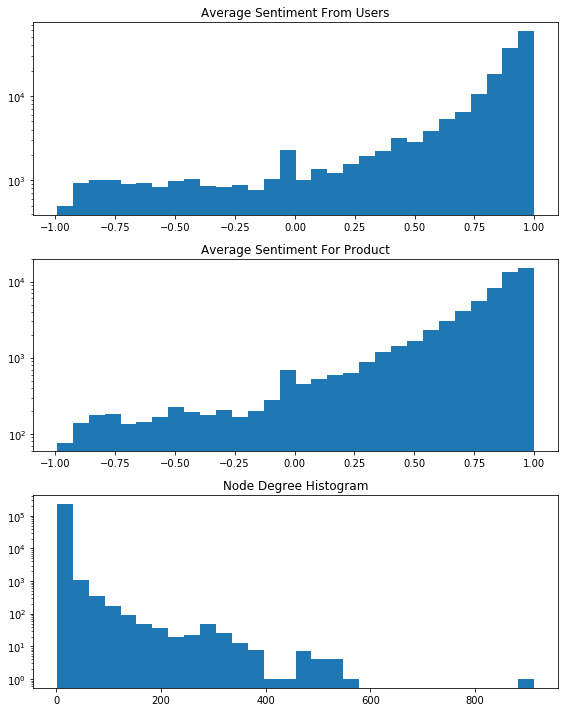

In [347]:
fig, axs = plt.subplots(3,figsize=(8, 10))

axs[0].hist(df_avg_from_user['Average Sentiment'], bins = 30)
axs[0].set_yscale("log")
axs[0].set_title('Average Sentiment From Users')


axs[1].hist(df_avg_for_product['Average Sentiment'], bins = 30)
axs[1].set_yscale("log")
axs[1].set_title('Average Sentiment For Product')

axs[2].hist(dict(G.degree()).values(), bins = 30)
axs[2].set_yscale("log")
axs[2].set_title('Node Degree Histogram')

fig.tight_layout()
fig.show()

## Graphs


It is obvious that the sentiment and raw review score skew heavily to the positive.  Thus, it may not be relevant to partition the network by simply Positive vs Negative classifcation.
<BR>We will proceed with the goal of delivering two networks.  Both will be filtered using an "Island Method."  However, the first('users_top') will be a prjection of the users on the high end of average sentiment score, while the second('users_bottom') stem from the other end.  

In [522]:
user_stats = df_avg_from_user['Average Sentiment'].describe()
users_top = df_avg_from_user['Average Sentiment'][df_avg_from_user['Average Sentiment']>user_stats['75%']].index.to_list()
users_bottom = df_avg_from_user['Average Sentiment'][df_avg_from_user['Average Sentiment']<user_stats['25%']].index.to_list()

In [724]:
def trim_nodes(g, degrees=1):
    nodes = []
    for n in g.nodes():
        if g.degree(n) > degrees:
            nodes.append(n)
    G2 = g.subgraph(nodes)
    return G2

In [ ]:
#modifiction of code clock found on Social Network Analysis for Startups, pg64 
def trim_edges(g, attribute,  weight=.5):
    l = []
    g2 = g.copy(as_view=False)
    for f, to, edata in g.edges(data=True):
            if (edata[attribute] < weight):
                l.append((f,to))
    v = []            
    for x in l:
            if x not in v:
                v.append(x)
    g2.remove_edges_from(v)
    g3 = nx.subgraph(g2, list(nx.connected_components(g2))[0])
    return g3

In [655]:
#modifiction of code clock found on Social Network Analysis for Startups, pg44
def snowball_sampling(g, center,node_limit, max_depth=1, current_depth=0, taboo_list=[]):
    #print(center, current_depth, max_depth, taboo_list)
    if (current_depth==max_depth) or (len(taboo_list)>node_limit):
        #if we have reached the depth limit of the search, return.
        #print('out of depth')
        return taboo_list
    if center in taboo_list:
        #we've been here before -- return right away
        return taboo_list
    else:
        taboo_list.append(center) # we shall never return to the same node
    for node in g.neighbors(center):
        # Iterate through all friends of the central node, call snowball_sampling recursively
        taboo_list=snowball_sampling(g, node, node_limit,current_depth=current_depth+1,max_depth=max_depth, taboo_list=taboo_list)
    return taboo_list

In [770]:
def graph_template(g, nodes):
    sub_g = nx.subgraph(g,nodes)
    pos = nx.kamada_kawai_layout(sub_g)
    line_w = np.array(nx.get_edge_attributes(sub_g, 'compound').values())
    line_col = np.array(nx.get_edge_attributes(sub_g, 'Sentiment').values())
    node_size = np.array(list(dict(sub_g.degree()).values()))
    node_col = np.array(list(nx.get_node_attributes(sub_g,'Average Sentiment').values()))
    #node_labs = nx.get_node_attributes(sub_g, 'Average Sentiment')

    fig, ax = plt.subplots(figsize=(15, 15))
    nx.draw(
            sub_g,
            pos = pos, 
            alpha =.7, 
            width = .1, 
            arrows=False ,
            #edge_color= line_col,
            #edge_cmap = plt.cm.spring, 
            #node_size = node_size , 
            #node_color= node_col, 
            #cmap =plt.cm.winter 
           )
    #ax.margins(-.20, -.20)
    fig.tight_layout()
    plt.axis("off")
    plt.show()

In [771]:
U_top = nx.bipartite.overlap_weighted_projected_graph(G,users_top)
U_bottom = nx.bipartite.overlap_weighted_projected_graph(G,users_bottom)

In [772]:
U_top_trim = trim_nodes(U_top, degrees=10)
U_bottom_trim = trim_nodes(U_top, degrees=10)

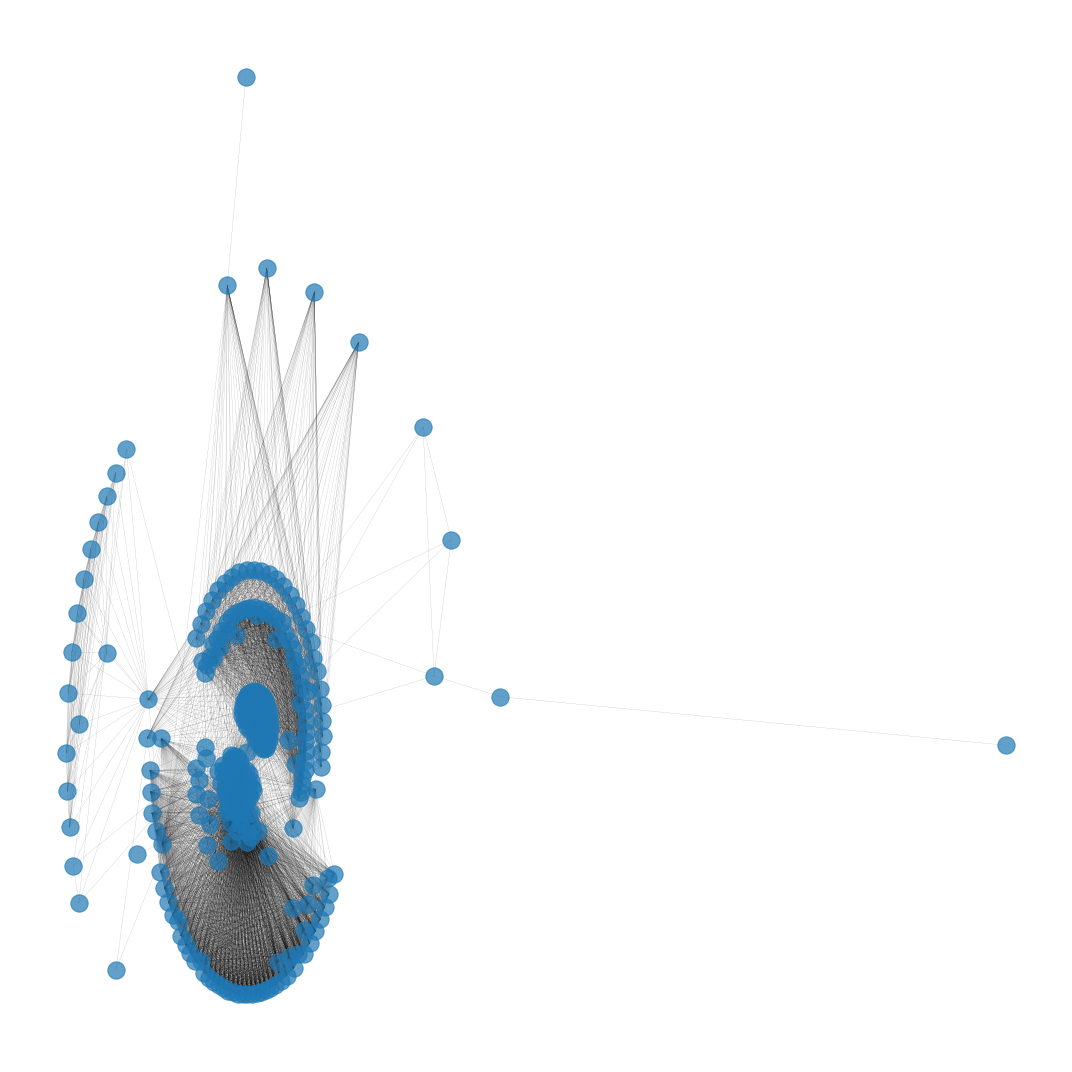

In [775]:
graph = U_top_trim
centralnode = random.sample(graph.nodes(),1)[0]
nodes = snowball_sampling(graph, centralnode, node_limit = 300, max_depth=10, current_depth=0, taboo_list=[])
graph_template(graph, nodes)



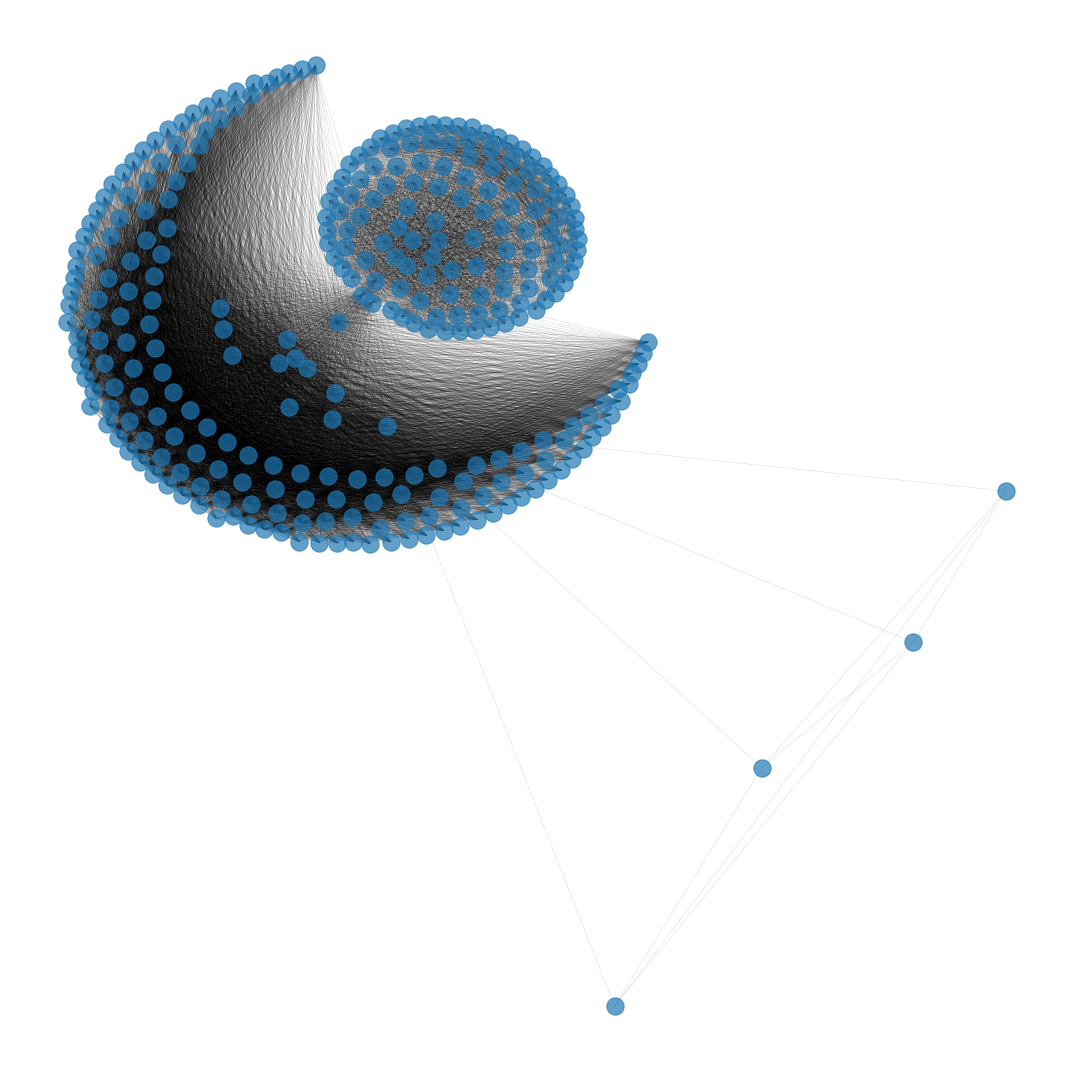

In [774]:
graph = U_bottom_trim
centralnode = random.sample(graph.nodes(),1)[0]
nodes = snowball_sampling(graph, centralnode, node_limit = 300, max_depth=10, current_depth=0, taboo_list=[])
graph_template(graph, nodes)



## Comparison


## Conclusion

---

<b>Citation: </b> 


---

<b>Additional Resources: </b> 
